This project according was done according to module assignment found at
https://cw.fel.cvut.cz/b212/courses/mpv/labs/5_convolutional_networks/start#training_own_network

In [ ]:
# Download dataset and unzip

!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xzf imagenette2-160.tgz

--2022-12-30 11:02:50--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.42.214, 52.217.87.238, 52.216.41.96, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.42.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99003388 (94M) [application/x-tar]
Saving to: ‘imagenette2-160.tgz’

imagenette2-160.tgz 100%[===================>]  94.42M  27.6MB/s    in 3.4s    

2022-12-30 11:02:54 (27.6 MB/s) - ‘imagenette2-160.tgz’ saved [99003388/99003388]



In [ ]:
# pip install libraries not standard to collab

!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 10.3 MB/s 


In [ ]:
#Import all the neccessary libraries

import matplotlib.pyplot as plt
import numpy as np
import kornia as K
import torchvision.transforms as tfms
from tqdm.notebook import tqdm
import torch
import torchvision as tv
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import ImageFolder
import zipfile

In [ ]:
# Check if a cuda machine and assign it to used device variable otherwise default to cpu

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

#def CalculateStatistics(dl):

def CalculateStatistics(dl):
    '''Function, that calculates mean and std of a dataset (pixelwise)
    Return:
        tuple of Lists of floats. len of each list should equal to number of input image/tensor channels
    '''
    mean=0.0
    std=0.0
    no_images=0
    for images,i in dl:
        images = images.view(images.size(0), images.size(1), -1)
        mean+=images.mean(dim=2).sum(dim=0)
        std+=images.std(dim=2).sum(dim=0)
        no_images+=images.size(dim=0)
    mean/=no_images
    std/=no_images
    return mean, std

In [ ]:
# Defines a class DecolorImagesDatasets which inheriting from torchvision.datasets.ImageFolder with altered __getitem__ to return a grayscale image

class DecolorImagesDataset(ImageFolder):
    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        out = K.color.rgb_to_grayscale(sample).expand(3, -1, -1), sample
        return out

In [ ]:
# Defines a temperory dataloader for obtaining dataset statistics

temp_transform = Compose([tfms.Resize((128,128)), ToTensor()])
temp_dataset = ImageFolder(root='imagenette2-160/train/', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16, drop_last=True)
mean, std = CalculateStatistics(temp_loader) # Calculates statistics

# Using the mean and std defines a torchvision.transforms.normalizer for aid in convergence in later training of CNN
normalizer = Normalize(mean=mean, std=std)

In [ ]:
# Defines the transforms that will be applied to data as it is read
train_transform = tfms.Compose([tfms.Resize((128,128)),      # Converts to 128x128 pixels image
                                tfms.RandomHorizontalFlip(), # Randomly flips is the orientation when it is read to aid in training
                                tfms.ToTensor(),             # Converts image to torch tensor
                                normalizer])                 # Normalises data for easy of training

test_transform = tfms.Compose([tfms.Resize((128,128)), # Converts to 128x128 pixels image
                                tfms.ToTensor(),       # Converts image to torch tensor
                                normalizer])           # Applies normlisation for consistency

ImageNette_train = DecolorImagesDataset('imagenette2-160/train',transform = train_transform)
ImageNette_test = DecolorImagesDataset('imagenette2-160/val', transform = test_transform)

# Defines small batch size
BS = 16

# Defines training and testing datasets validation dataset is not neccessary over
train_dl = torch.utils.data.DataLoader(ImageNette_train, batch_size= BS,shuffle = True)

test_dl = torch.utils.data.DataLoader(ImageNette_test, batch_size= 2,shuffle = True, drop_last=False)


[Unet](https://arxiv.org/abs/1505.04597) is a particular type of CNN archecture that takes an input image to generate an output image, a typical unet archecture can be used is seen in the figure.

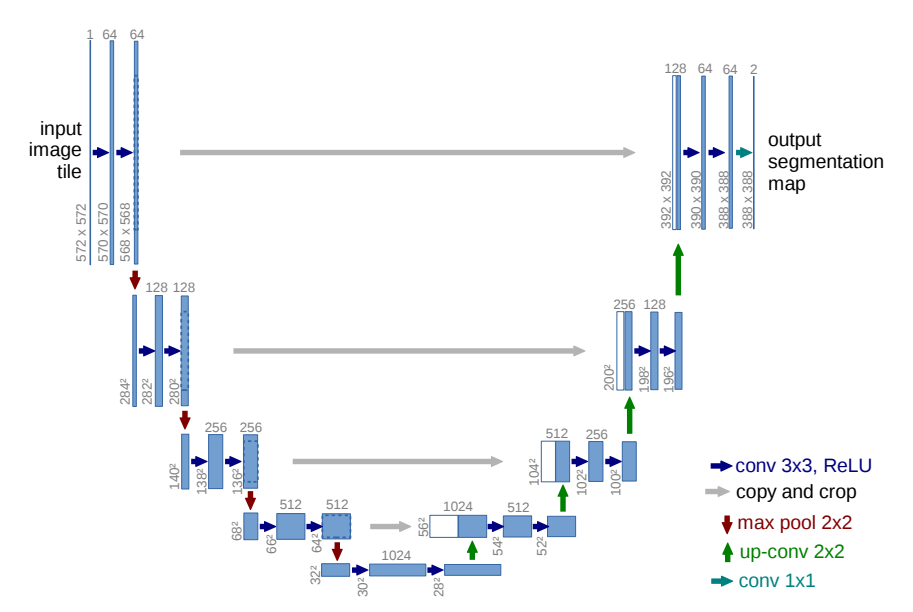

The image is taken from: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5

The Unet consists of a few main components:

**Encoder**: This components takes in an input image and following a series convolutions, normalisation and rescalings, outputs a vector of floats. This resembles a typical CNN archecture. The only difference is that each solution of each layer of the CNN stored in a list for later use, and all pooling layers are replaced by rescaling layers is used.

**Decoder**: This componects takes in a vector of floats then following a series convolutions, normalisations, rescalings, and skip connections outputs an image.

**Skip Connections**: This refers to the gray arrows in the diagram, what they do is take in the output a particular of an CNN layer and concatenates it to another. In diagram it can be seen the saved output of each Encoder layer is concatenated onto the corresponding Decoder layer.





Of course UNET's can and have been implemented in countless different forms, the particular implemention used in this project takes advantage of transfer learning. A pretrained [VGGNet](https://arxiv.org/pdf/1409.1556) is taken as the encoder replacing all the pooling layer for rescaling layers and its freezing its weights whilst the decoder is created and trained within the project. It was found having a pretrained encoder and only needing to train the decoder significantly reduced training time and improved results.

In [ ]:
# Takes the pretrained encoder and creates the UNET class

class UnetModel(torch.nn.Module):
    def __init__(self, encoder):
        super(UnetModel, self).__init__()
        modules=[]
        temp = []
        for i, l in enumerate(encoder):
          try:
            stride = l.stride
          except:
            stride = 1
            temp.append(l)
          if type(stride) is tuple:
              temp.append(l)
              stride = stride[0]
          if stride > 1:
            temp.append(K.geometry.transform.Rescale(0.5, antialias=True))
            modules.append(torch.nn.Sequential(*temp))
            temp=[]
        self.down_blocks = torch.nn.ModuleList(modules)
        for parameter in self.down_blocks:
          parameter.requires_grad = False

        self.up_blocks = torch.nn.ModuleList([torch.nn.Sequential(K.geometry.transform.Rescale((2,2)),
                                      torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,512, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1)),

                         torch.nn.Sequential(K.geometry.transform.Rescale((2,2)),
                                      torch.nn.Conv2d(512+512, 256, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,256, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1),
                                      torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,256, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1)),

                         torch.nn.Sequential(K.geometry.transform.Rescale((2,2)),
                                      torch.nn.Conv2d(256+256, 128, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,128, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1),
                                      torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,128, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1)),

                        torch.nn.Sequential(K.geometry.transform.Rescale((2,2)),
                                      torch.nn.Conv2d(128+128, 64, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,64, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1),
                                      torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                      torch.nn.GroupNorm(8,64, eps=1e-05),
                                      torch.nn.LeakyReLU(negative_slope=0.1))])


        self.final = torch.nn.Sequential(K.geometry.transform.Rescale((2,2)),torch.nn.Conv2d(64+64, 3, kernel_size=(3,3), stride=1, padding=1))
        return
    def forward(self, input):
        store = []
        x = input
        for i, bl in enumerate(self.down_blocks):
          x= bl(x)
          store.append(x)
          #print(i,x.shape)
        for i, bl in enumerate(self.up_blocks):
          x= bl(x)
          if(i<len(store)):
            #print(x.shape, store[len(store)-i-2].shape)
            x = torch.concat([store[len(store)-i-2],x],dim=1)

        x=self.final(x)
        return x

vgg13 = tv.models.vgg13_bn(True)
unet = UnetModel(vgg13.features)
unet.to(device)
print(unet)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


  0%|          | 0.00/508M [00:00<?, ?B/s]

UnetModel(
  (down_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Rescale()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Rescale()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3),

Naive approach to calculating training loss would be to use a mean squared error between the pixels in the target image and output image of the model, but has been this can result in blurry images.

Instead perceptual loss as outlined in [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf) was used. This loss functions compares the difference of 2 images but inputing them into a frozen pretrained CNN network and compares the mean squared difference between the output of the two images at each layer. This gives a  measure of the difference in the features of two images as oppose to pixel values.

For the implementation of this project the first 11 layer of a pretrained alexnet was chosen. This choses was somewhat abitrary just differing fromt the artecture used in the UNET to avoid on forseen biases.

In [ ]:
class ContentLoss(torch.nn.Module):
    def __init__(self, layer_id = 11):
        super(ContentLoss, self).__init__()
        features = tv.models.alexnet(True).features[:layer_id]
        blocks = []
        blocks.append(features[:2].eval())
        blocks.append(features[2:5].eval())
        blocks.append(features[5:11].eval())
        for bl in blocks:
          for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.blocks.to(device)
        self.loss=0.0
        return

    def forward(self, input, target):
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            with torch.no_grad():
              y = block(y)
            loss += torch.nn.functional.mse_loss(x, y)
        return loss

Tuning the learning rate is a delicate process as with too high a learning rate it is possible you will over shot the minimum, whilst on the other hand, too low a learning rate your model may get stuck in a local minimum and never reach the global minimum.

In this section, a search for the optimimum learning rate is performed by initially starting with a very low learning rate which is gradually increased with each epochs and the loss recorded.

In [ ]:
# Defines temp data loader for searching for an optimum learning rate
temp_dl = torch.utils.data.DataLoader(ImageNette_train, batch_size= 16,shuffle = True)

epochs = 1
losses = []

vgg13 = tv.models.vgg13(True)
unet = UnetModel(vgg13.features)
unet.to(device)
LossFunc = ContentLoss()
losses=[]


LearningRates = np.logspace(-8, -0.5, len(temp_dl))
for e in range(epochs):
    num_batches = len(temp_dl)
    for batch_idx, batch in  tqdm(enumerate(temp_dl), total=num_batches):
        Optimizer = torch.optim.Adam(list(unet.up_blocks.parameters()) + list(unet.final.parameters()),lr=LearningRates[batch_idx])
        input = batch[0].to(device)
        target = batch[1].to(device)
        with torch.set_grad_enabled(True):
            out = unet(input)
            loss = LossFunc(out, target)
            loss.backward()
            Optimizer.step()
            Optimizer.zero_grad()
        losses.append(loss.item()/input.shape[0])

  0%|          | 0/592 [00:00<?, ?it/s]

The graph shows the typically loss curve associated with this sort of training, with a global be minimum being visible around 1e-3, which indicative of the optimum learning rate.



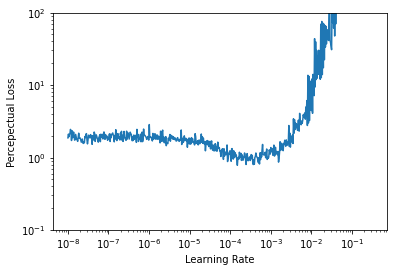

In [ ]:
plt.figure()
plt.plot(LearningRates, losses)
plt.xlabel("Learning Rate")
plt.ylabel("Percepectual Loss")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 1e2)
plt.show()

In [ ]:
# Model Trainining

BS = 16

# Defines training and testing datasets validation dataset is not neccessary over
train_dl = torch.utils.data.DataLoader(ImageNette_train, batch_size= BS,shuffle = True)

epochs = 10

#vgg13 = tv.models.vgg13(True)
#unet = UnetModel(vgg13.features)
#unet.to(device)

LossFunc = ContentLoss()
Optimizer = torch.optim.Adam(list(unet.up_blocks.parameters()) + list(unet.final.parameters()),lr=1e-3)

#losses=[]
unet.train()
for e in range(epochs):
    TrainLossSum=0
    num_batches = len(train_dl)
    for batch_idx, batch in  tqdm(enumerate(train_dl), total=num_batches):
        input = batch[0].to(device)
        target = batch[1].to(device)
        with torch.set_grad_enabled(True):
            out = unet(input)
            loss = LossFunc(out, target)
            loss.backward()
            Optimizer.step()
            Optimizer.zero_grad()
            TrainLossSum+=loss.item()/input.shape[0]
    TrainLossSum/=num_batches
    print(f'Train Loss: {TrainLossSum}',end ="   ")
    losses.append(TrainLossSum)

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.20961217420357675   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.207701833064817   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.20510433909334164   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.2036980806003768   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.20085344558848908   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.19989252051148804   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.19591540478851469   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.19612349198236595   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.19347351302708385   

  0%|          | 0/592 [00:00<?, ?it/s]

Train Loss: 0.19105614362993198   

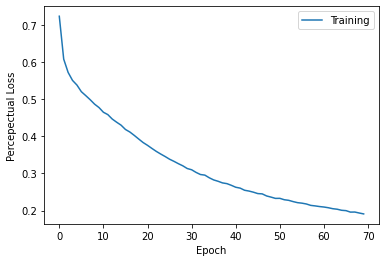

In [ ]:
plt.figure()
plt.plot(losses, label='Training')
plt.xlabel("Epoch")
plt.ylabel("Percepectual Loss")
plt.legend()
plt.show()

In [ ]:
def RescaleAndNormalise(timg):
    out1 = (timg.cpu()+torch.tensor(mean).view(1,3,1,1))*torch.tensor(std).view(1,3,1,1)
    out2 = 255*(out1-out1.min()) / (out1.max() - out1.min())
    return out2.byte()
def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

unet.eval()

color_orig_normalized = []
gray_orig_normalized = []
color_predicted_normalized = []
count = 0
for gray, color in test_dl:
    with torch.no_grad():
        colorized = unet(gray.to(device))
    if count <5:
      color_orig_normalized += [RescaleAndNormalise(x.unsqueeze(0)) for x in color]
      gray_orig_normalized += [RescaleAndNormalise(x.unsqueeze(0)) for x in gray]
      color_predicted_normalized += [RescaleAndNormalise(x.unsqueeze(0)) for x in colorized]
    else:
      break
    count+=1
imshow_torch_channels(torch.cat(color_orig_normalized,dim=0),0)
imshow_torch_channels(torch.cat(gray_orig_normalized,dim=0),0)
imshow_torch_channels(torch.cat(color_predicted_normalized,dim=0),0)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Save Trained Model
torch.save(unet.state_dict(), "./TrainedUnet")

In [ ]:
# Reload Trained Model
vgg13 = tv.models.vgg13(True)
unet = UnetModel(vgg13.features)
unet.to(device)
unet.load_state_dict(torch.load("./TrainedUnet"))